In [108]:
words = open('names.txt', 'r', encoding='utf-8').read().splitlines()
print(words[-3:])
print(len(words))

['zyrie', 'zyron', 'zzyzx']
32033


In [109]:
letters = sorted(list(set(''.join(words)))) # Get all individual letters sorted, should be alphabet (if all letters are once included in our names)
num_of_unique_letters = len(letters) + 1 # Add 1 for '.' our special char
stoi = {s:i+1 for i,s in enumerate(letters)} # Create a mapping from a char to a int in order to index in tensor
stoi['.'] = 0 # Add . as a special char
itos = {i:s for s,i in stoi.items()} # Create the mapping in reverse
print(num_of_unique_letters)
print(letters)
itos

27
['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']


{1: 'a',
 2: 'b',
 3: 'c',
 4: 'd',
 5: 'e',
 6: 'f',
 7: 'g',
 8: 'h',
 9: 'i',
 10: 'j',
 11: 'k',
 12: 'l',
 13: 'm',
 14: 'n',
 15: 'o',
 16: 'p',
 17: 'q',
 18: 'r',
 19: 's',
 20: 't',
 21: 'u',
 22: 'v',
 23: 'w',
 24: 'x',
 25: 'y',
 26: 'z',
 0: '.'}

In [110]:
def build_data(words, nChars):
    x, y = [], []
    for w in words:
        chs = list('.'*nChars + w + ".")
        chs = [stoi[c] for c in chs]
        for i in range(len(chs)-nChars):
            x.append(chs[i:i+nChars])
            y.append(chs[i+nChars])
    return (x,y)

# Example 'zuzanna' becomes training example (.. -> z, ..z -> u, and so on until last nna -> .) and chars are converted to the ints

nChars = 3
print(words[-1:])
print(build_data(words[-1:], nChars))

['zzyzx']
([[0, 0, 0], [0, 0, 26], [0, 26, 26], [26, 26, 25], [26, 25, 26], [25, 26, 24]], [26, 26, 25, 26, 24, 0])


In [111]:
import torch
import torch.nn.functional as F
import torch.nn as nn
import random
import matplotlib.pyplot as plt
%matplotlib inline

In [112]:
g = torch.Generator().manual_seed(2147483647)

random.shuffle(words)
trainIdx = int(0.8*len(words))
valIdx = int(0.9*len(words))

xTrain, yTrain = build_data(words[0:trainIdx], nChars)
xTrain = torch.tensor(xTrain)
yTrain = torch.tensor(yTrain)

xVal, yVal = build_data(words[trainIdx:valIdx], nChars)
xVal = torch.tensor(xVal)
yVal = torch.tensor(yVal)

xTest, yTest = build_data(words[valIdx:], nChars)
xTest = torch.tensor(xTest)
yTest = torch.tensor(yTest)


nC = 5 # Look up table, can also be seen as the first layer to our network
nHiddenN = 100 # Size of hidden layer

C = torch.randn((num_of_unique_letters, nC), generator=g)

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        
        self.l1 = torch.nn.Linear(nC*nChars, nHiddenN, bias=False)
        self.bn1 = torch.nn.BatchNorm1d(nHiddenN)
        self.tanh1 = torch.nn.Tanh()
        
        self.l2 = torch.nn.Linear(nHiddenN, nHiddenN, bias=False)
        self.bn2 = torch.nn.BatchNorm1d(nHiddenN)
        self.tanh2 = torch.nn.Tanh()
        
        self.l3 = torch.nn.Linear(nHiddenN, nHiddenN, bias=False)
        self.bn3 = torch.nn.BatchNorm1d(nHiddenN)
        self.tanh3 = torch.nn.Tanh()
        
        self.l4 = torch.nn.Linear(nHiddenN, nHiddenN, bias=False)
        self.bn4 = torch.nn.BatchNorm1d(nHiddenN)
        self.tanh4 = torch.nn.Tanh()

        self.l5 = torch.nn.Linear(nHiddenN, num_of_unique_letters, bias=False)
        self.bn5 = torch.nn.BatchNorm1d(num_of_unique_letters)
        
    def forward(self, x):
        x = self.l1(x)
        x = self.bn1(x)
        x = self.tanh1(x)
        
        x = self.l2(x)
        x = self.bn2(x)
        x = self.tanh2(x)
        
        x = self.l3(x)
        x = self.bn3(x)
        x = self.tanh3(x)
        
        x = self.l4(x)
        x = self.bn4(x)
        x = self.tanh4(x)
        
        x = self.l5(x)
        x = self.bn5(x)
        return x
    
net = Net()
print(net)

loss_fn = F.cross_entropy
optimizer = torch.optim.Adam(net.parameters(), lr=0.1)

trL = []
vaL = []

Net(
  (l1): Linear(in_features=15, out_features=100, bias=False)
  (bn1): BatchNorm1d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (tanh1): Tanh()
  (l2): Linear(in_features=100, out_features=100, bias=False)
  (bn2): BatchNorm1d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (tanh2): Tanh()
  (l3): Linear(in_features=100, out_features=100, bias=False)
  (bn3): BatchNorm1d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (tanh3): Tanh()
  (l4): Linear(in_features=100, out_features=100, bias=False)
  (bn4): BatchNorm1d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (tanh4): Tanh()
  (l5): Linear(in_features=100, out_features=27, bias=False)
  (bn5): BatchNorm1d(27, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)


In [113]:
epochs = 100_000
batch_size = 32
optimizer = torch.optim.Adam(net.parameters(), lr=0.01)

for epoch in range(epochs):

    # minibatch construct
    mIdx = torch.randint(0, xTrain.shape[0], (batch_size,))
    Yb = yTrain[mIdx] # batch Y
    
    # forward pass
    emb = C[xTrain[mIdx]] # embed the characters into vectors
    x = emb.view(emb.shape[0], -1) # concatenate the vectors
    
    x = net.forward(x)
    loss = loss_fn(x, Yb) # loss function

    # backward pass
    optimizer.zero_grad()
    loss.backward()

    # update
    optimizer.step()

    # track stats
    if epoch % 5_000 == 0: # print every once in a while
        Yb = yVal
        emb = C[xVal]
        x = emb.view(emb.shape[0], -1)
        x = net(x)
        vaLoss = loss_fn(x, Yb)
        vaL.append(loss.log10().item())
        
        print(f'{epoch:7d}/{epochs:7d}: tr: {loss.item():.4f}, va: {vaLoss.item():.4f}')
        
        
        
    trL.append(loss.log10().item())



      0/ 100000: tr: 3.9056, va: 3.6515
   5000/ 100000: tr: 2.8719, va: 2.2841
  10000/ 100000: tr: 2.1946, va: 2.2333
  15000/ 100000: tr: 2.1966, va: 2.2146
  20000/ 100000: tr: 2.4428, va: 2.2018
  25000/ 100000: tr: 2.1555, va: 2.1916
  30000/ 100000: tr: 2.3345, va: 2.1833
  35000/ 100000: tr: 2.2818, va: 2.1730
  40000/ 100000: tr: 1.8767, va: 2.1641
  45000/ 100000: tr: 2.2050, va: 2.1638
  50000/ 100000: tr: 2.0013, va: 2.1611
  55000/ 100000: tr: 2.3263, va: 2.1599
  60000/ 100000: tr: 2.1736, va: 2.1516
  65000/ 100000: tr: 2.3706, va: 2.1587
  70000/ 100000: tr: 2.1235, va: 2.1517
  75000/ 100000: tr: 2.3781, va: 2.1497
  80000/ 100000: tr: 2.0657, va: 2.1410
  85000/ 100000: tr: 2.5110, va: 2.1414
  90000/ 100000: tr: 2.2056, va: 2.1435
  95000/ 100000: tr: 1.9360, va: 2.1383


In [114]:
# Theoretical first loss should be around:
-torch.tensor([1/27]).log()

tensor([3.2958])

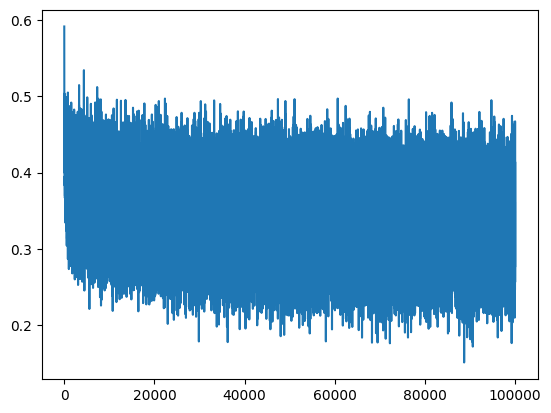

In [115]:
plt.plot(trL)

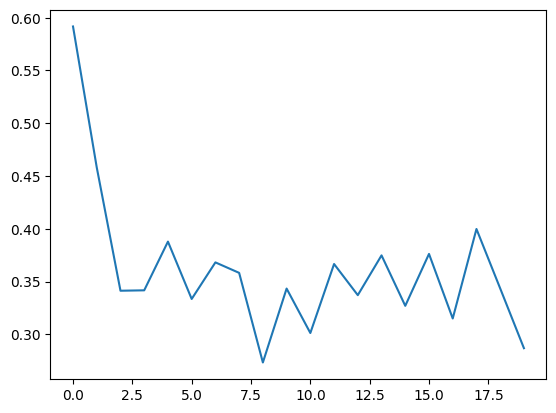

In [116]:
plt.plot(vaL)